In [2]:
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/pbs/home/c/cmurray/cluster_likelihood/modules/')
import simulation
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import corner
import pickle
import scipy.stats as stats
from matplotlib.cm import get_cmap
from torch.distributions import Distribution, Uniform, Normal
import pyccl as ccl
from matplotlib.cm import get_cmap

In [3]:
pinocchio_mock = np.load('/pbs/home/c/cmurray/cluster_likelihood/pinocchio_data_vector/data_vector_pinocchio_mock_log_normal_poisson_log_scatter_sigma_lnMwl=0.25.pkl' , allow_pickle= True )
pinocchio_mock = np.load('/pbs/home/c/cmurray/cluster_likelihood/pinocchio_data_vector/data_vector_pinocchio_mock_log_normal_poisson_scatter_sigma_lnMwl=0.25.pkl' , allow_pickle= True )

In [4]:
richness_cents = np.array( [ ( np.array( pinocchio_mock['richness_bins'] ).T[0] + np.array( pinocchio_mock['richness_bins'] ).T[1] )/2. ])[0]
redshift_cents = np.array( [ ( np.array( pinocchio_mock['redshift_bins'] ).T[0] + np.array( pinocchio_mock['redshift_bins'] ).T[1] )/2. ])[0]

In [5]:
richness_cents

array([ 25.84893192,  40.96779624,  64.92958137, 102.9064515 ,
       163.09573445])

In [6]:
richness_bins = list(np.array(pinocchio_mock['richness_bins']).T[0])
richness_bins.append( np.array( pinocchio_mock['richness_bins'] ).T[1][-1]  )

redshift_bins = list(np.array( pinocchio_mock['redshift_bins']).T[0])
redshift_bins.append( np.array( pinocchio_mock['redshift_bins'] ).T[1][-1]  )

In [7]:
redshift_bins

[0.2, 0.36, 0.52, 0.6799999999999999, 0.8400000000000001, 1.0]

In [8]:
richness_bins

[19.999999999999996,
 31.697863849222262,
 50.237728630191604,
 79.62143411069944,
 126.19146889603861,
 199.99999999999991]

In [9]:
pinocchio_mock['redshift_bins'] 

[[0.2, 0.36],
 [0.36, 0.52],
 [0.52, 0.6799999999999999],
 [0.6799999999999999, 0.8400000000000001],
 [0.8400000000000001, 1.0]]

In [10]:
richness_bins

[19.999999999999996,
 31.697863849222262,
 50.237728630191604,
 79.62143411069944,
 126.19146889603861,
 199.99999999999991]

In [11]:
stacked_simulator_pl = simulation.Universe_simulation( 'stacked_counts' ,
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )

stacked_simulator_pl.selection_richness = 0
stacked_simulator_pl.dOmega = 0.25 * 4 * np.pi
stacked_simulator_pl.richness_bins = richness_bins
stacked_simulator_pl.redshift_bins = redshift_bins
stacked_simulator_pl.sigma_mwl = 0.25
stacked_simulator_pl.include_mwl_measurement_errors = False
#stacked_simulator_pl.mwl_std = mwl_std
stacked_simulator_pl.correlation_mass_evolution = False
#stacked_simulator_pl.set_richness_mass_relation( 'power law' )
stacked_simulator_pl.set_richness_mass_relation( 'constantins model' )
stacked_simulator_pl.set_bins( z_bins = np.arange( 0.2 , 1 , 0.05 ) , 
                               log10m_bins=  np.arange( 14.2 , 16 , 0.0001))

stacked_simulator_pl.hmf = ccl.halos.MassFuncDespali16(mass_def='vir')

In [12]:
stacked_simulator_pl.dlog10m

9.999999999976694e-05

In [13]:
len( richness_cents ) , len( redshift_cents ) 

(5, 5)

In [14]:
# Use a colormap that goes from blue to red
cmap = get_cmap('coolwarm')

/tmp/ipykernel_50371/4130027877.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('coolwarm')


In [15]:
sim_obs = stacked_simulator_pl.run_simulation( torch.Tensor([ 0.307 , 0.83 , 0.67 , 2.2 , 3.2 , 0 , 0.5 ]))

0.3070000112056732 0.04918689886389122 0.6700000166893005 0.8299999833106995
81615 81615
3.200000047683716 0.0 2.200000047683716


In [16]:
sim_n_clusters = sim_obs[:25].reshape( len( richness_cents ) , len( redshift_cents )  ).T
sim_mwl_mean = sim_obs[25:].reshape( len( richness_cents ), len( redshift_cents ) ).T

In [17]:
np.sum( sim_n_clusters ) / np.sum( pinocchio_mock['mean_count_richness_redshift'] )

0.9779026345864295

/tmp/ipykernel_50371/2060782296.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim( 0 , 7000 )


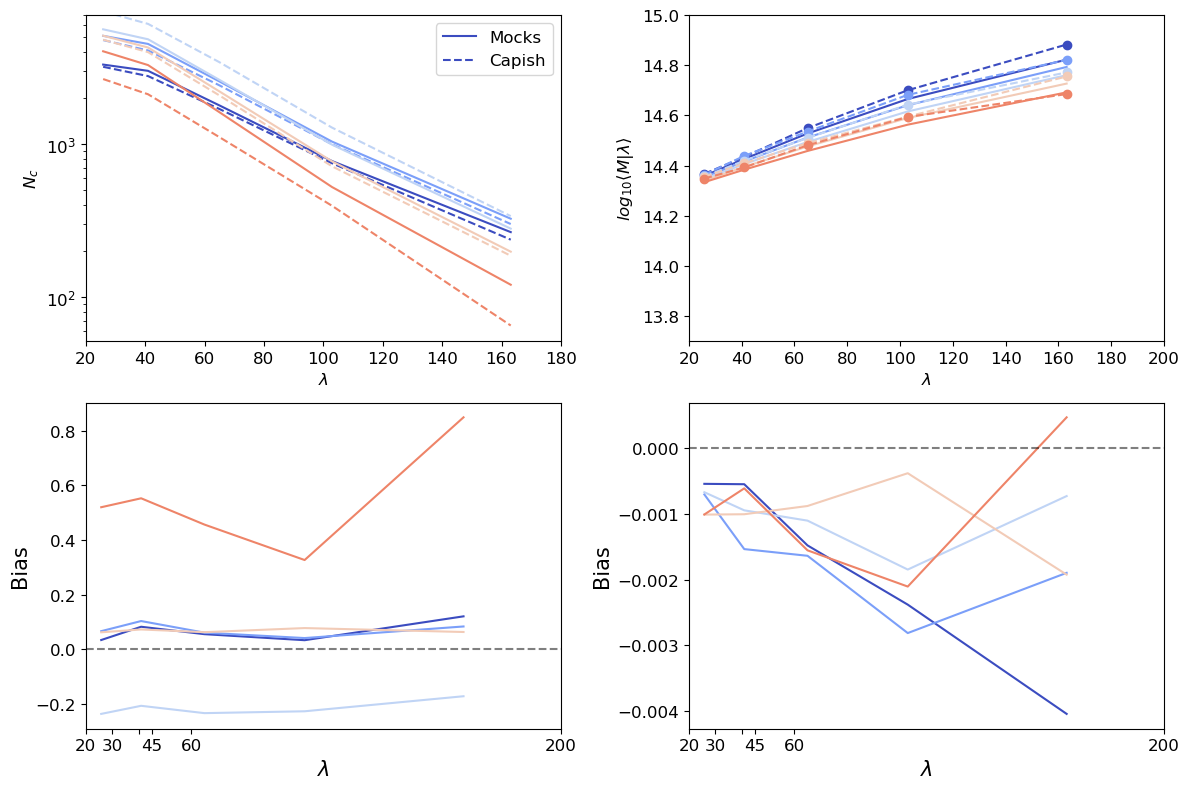

In [18]:
# Set the figure size
plt.figure(figsize=(12, 8))


plt.subplot(221)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    if i == 0:
        plt.plot( richness_cents , 
                 pinocchio_mock['mean_count_richness_redshift'].T[i] , '-'  , color = color , label = 'Mocks' )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters[i], '--' , color = color , label = 'Capish' )
    else:
        plt.plot( richness_cents , 
                 pinocchio_mock['mean_count_richness_redshift'].T[i] , '-'  , color = color )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters[i], '--' , color = color )

#plt.xscale('log')
plt.yscale('log')
plt.xlim( 20 , 180 )
plt.ylim( 0 , 7000 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$N_c$' , fontsize = 12 )
plt.legend( fontsize = 12 )

plt.subplot(222)

alpha = 2.2
c = 3.2 
sigma = 0.5
beta = 0

mu = np.log( np.logspace( 14.2 , 14.8 , 10 )/1e14 )

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_log10mass_richness_redshift'].T[i] ) , '-' , color = color )# , drawstyle = 'steps-mid')
    plt.plot( richness_cents , sim_mwl_mean[i] , 'o--' , color = color )

#plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 13.7 , 15 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$log_{10}\left< M | \lambda \right>$' , fontsize = 12 )

plt.subplot(223)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_count_richness_redshift'].T[i] - sim_n_clusters[i] )/sim_n_clusters[i] , '-'  , color = color )#, drawstyle = 'steps-mid')
    
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
#plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Bias', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )
#plt.ylim( -0.3 , 0.3 )

# Subplot 4: Residuals for MWL
plt.subplot(224)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_log10mass_richness_redshift'].T[i] - sim_mwl_mean[i] )/sim_mwl_mean[i] , '-' , color = color )# , drawstyle = 'steps-mid')

plt.axhline(0, color='k', linestyle='--', alpha=0.5)
#plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Bias', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [161]:
stacked_simulator_pl.dlog10m

9.999999999976694e-05

In [162]:
# # Define individual priors with correct tensor shape
# prior_om = Uniform(torch.tensor([0.05]), torch.tensor([1.0]))
# prior_s8 = Uniform(torch.tensor([0.5]), torch.tensor([1.5]))
# prior_h = Normal(torch.tensor([0.7]), torch.tensor([0.1]))  # Normal prior on h
# prior_alpha = Uniform(torch.tensor([0.4]), torch.tensor([1.2]))
# prior_c = Uniform(torch.tensor([1.0]), torch.tensor([5.0]))
# prior_beta = Uniform(torch.tensor([-5.0]), torch.tensor([5.0]))
# prior_sigma = Uniform(torch.tensor([0.05]), torch.tensor([0.5]))

# # Combine the priors into a list for processing
# priors = [ prior_om, prior_s8, prior_h, prior_alpha, prior_c , prior_beta , prior_sigma ]

In [163]:
# # infer posteriors
# pinocchio_posterior = infer( stacked_simulator_pl.run_simulation , 
#                              priors, 
#                              method = 'SNPE', 
#                              num_simulations = 1000 , 
#                              num_workers = 1 )

In [164]:
import pyccl as ccl

In [165]:
# cannot repruce the DES sigma8 value from their A_s value
# could be the average of the posterior space is simply the issue
h0 = 0.67

cosmo_params = {'Omega_c': 0.18, 
                'Omega_b': 0.02208 / h0**2,
                'h': h0,    
                'n_s': 0.96,
                'A_s': np.exp(3.7)/1e10,   # DES Y1 clusters value
                'Omega_k': 0.0 ,
                'matter_power_spectrum': 'linear',
                'transfer_function': 'boltzmann_camb',
               }

# Create the CCL Cosmology object
cosmo = ccl.Cosmology(**cosmo_params)
print(cosmo.sigma8())

0.8752975706110139


In [166]:
def dVdzdOmega(z, cosmo):
    r"""
    Attributes:
    ----------
    z : float
        redshift
    cosmo: CCL cosmology
        cosmological parameters
    Returns:
    -------
    dVdzdOmega_value : float
        differential comoving volume 
    """
    a = 1./(1. + z)
    da = ccl.background.angular_diameter_distance(cosmo, a)
    ez = ccl.background.h_over_h0(cosmo, a) 
    dh = ccl.physical_constants.CLIGHT_HMPC / cosmo['h']
    dVdzdOmega_value = dh * da * da/( ez * a ** 2)
    return dVdzdOmega_value

In [20]:
cosmo.comoving_volume_element( 1/(1+0.5))

29283267660.79649

In [21]:
dVdzdOmega( 0.5 , cosmo )

13014785627.020662

In [34]:
z_bins = np.linspace( 0.1 , 2 )
z_cents = ( z_bins[1:] + z_bins[:-1] )

In [43]:
z_bins = np.arange( 0.1 , 2 , 0.05 )
z_cents = ( z_bins[1:] + z_bins[:-1] )/2.

scale_factor_bins = 1/( z_bins + 1 )
scale_factors = 1 / ( z_cents  + 1)

# Compute comoving volumes only once
dV = cosmo.comoving_volume_element( scale_factors ) 
da = scale_factor_bins[:-1] - scale_factor_bins[1:]
dz = z_bins[:-1] - z_bins[1:]

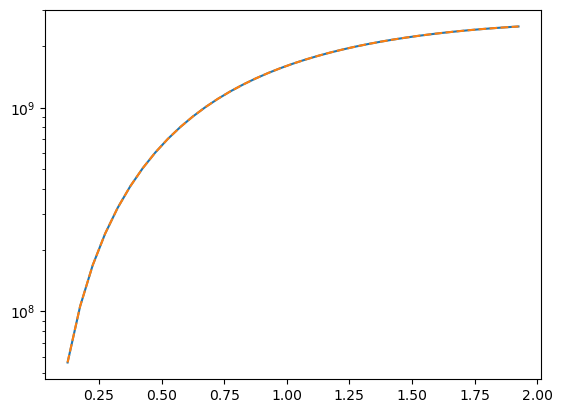

In [46]:
plt.plot( z_cents ,  -dVdzdOmega( z_cents , cosmo ) * dz  )
plt.plot( z_cents ,  cosmo.comoving_volume_element( 1/ ( 1 + z_cents ) ) * da , '--' )
plt.yscale('log')

In [39]:
dVdzdOmega( z_cents , cosmo ) * dz 

array([-1.45011397e+08, -2.38339053e+08, -3.45115254e+08, -4.60680515e+08,
       -5.81033048e+08, -7.02848644e+08, -8.23456904e+08, -9.40787479e+08,
       -1.05329947e+09, -1.15990392e+09, -1.25988611e+09, -1.35283258e+09,
       -1.43856812e+09, -1.51709842e+09, -1.58856531e+09, -1.65320765e+09,
       -1.71133033e+09, -1.76328065e+09, -1.80943100e+09, -1.85016425e+09,
       -1.88586262e+09, -1.91690031e+09, -1.94363625e+09, -1.96642102e+09,
       -1.98557603e+09, -2.00140969e+09, -2.01420983e+09, -2.02424302e+09,
       -2.03175663e+09, -2.03697922e+09, -2.04011893e+09, -2.04136844e+09,
       -2.04091386e+09, -2.03890560e+09, -2.03550722e+09, -2.03084024e+09,
       -2.02504375e+09, -2.01822433e+09, -2.01048321e+09, -2.00192129e+09,
       -1.99262721e+09, -1.98267926e+09, -1.97214623e+09, -1.96109483e+09,
       -1.94958597e+09, -1.93767465e+09, -1.92541046e+09, -1.91283781e+09,
       -1.89999843e+09])

In [ ]:
stacked_simulator_pl.hmf()